# Strategy


The transformation of unstructured data into vector embeddings gives new structured representaions of data such as those produced by LLM encodings.

We have tested various vector similarity search algorithms with kdb+ testing these algorithms for both speed and accuracy.
  
Here we use similarity search in a timeseries context to develop a momentum trading strategy for a collection of nine crypto currency assets.

### Resource Constraints

In [1]:
### ASSETS can be set between 1-9 inclusive
### To run for the full porfolio set ASSETS=9 (Requires 32GB RAM)
### To run for a single asset set ASSETS=1 (Requires 16GB RAM)
### Please make sure this parameter aligns with that used in Setup.ipynb

ASSETS = 1

### Install and Load Dependencies

In [2]:
## Uncomment this `pip install` command if you see import errors
# %pip install --quiet matplotlib plotly umap-learn

In [3]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from umap import UMAP
import pykx as kx
kx.q('\l init.q')

pykx.Identity(pykx.q('::'))

### Load Vectors : Momentum Signals

Each vector consists of a collection of momentum signals taken from crypto prices. We have sampled the data at one minute intervals. The training set consists of approximately two years of data on nine assets while the test set consists of just over two months of out of sample data.

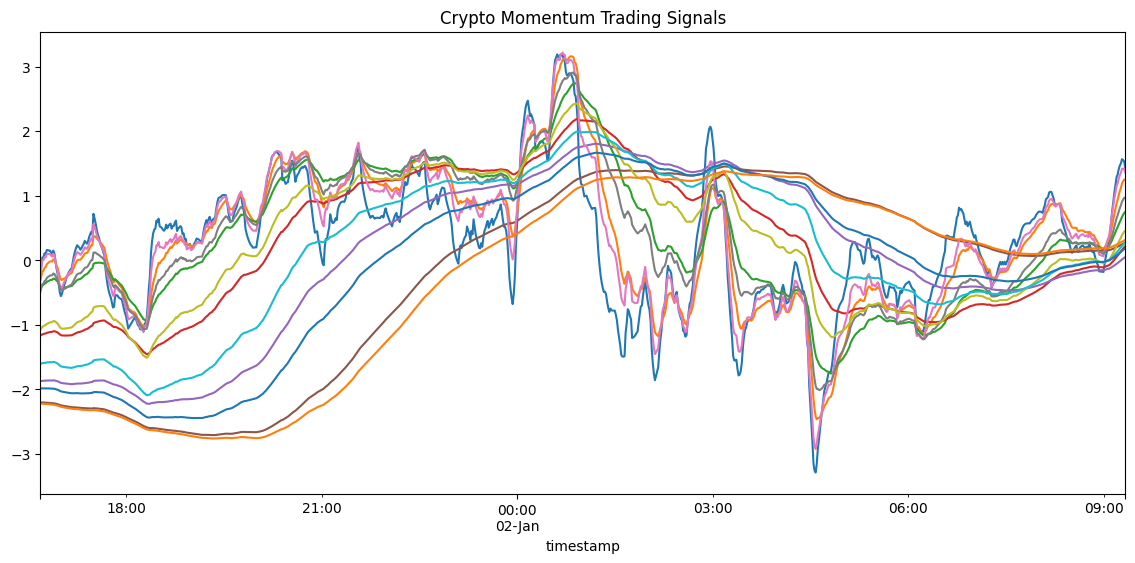

In [4]:
train = kx.q("get `:/tmp/train")
test  = kx.q("get `:/tmp/test")

train = kx.q.qsql.update(train,columns={'vector':kx.q.enlist(kx.q.flip(train[['signal_'+str(i) for i in range(36)]]))})
test  = kx.q.qsql.update(test,columns={'vector':kx.q.enlist(kx.q.flip(test[['signal_'+str(i) for i in range(36)]]))})

sample = train[1000:2000].pd()
sample.index = sample.timestamp
sample = sample[['signal_'+str(i) for i in range(36) if i%2 == 0 and i > 10]]

fig,ax=plt.subplots(1,figsize=(14,6))
ax.set_title('Crypto Momentum Trading Signals')
sample.plot(ax=ax)
ax.get_legend().remove()
plt.show()

### Build Search Index : Inverted File Index with Product Quantization

In order to perform vector similarity search we use an approximate nearest neighbors algorithm. Here we are using an inverted file index with product quantization. 

Rather than do a brute force nearest neighbors search this index compresses the data to allow for faster computation and partitions the collection of vectors into clusters to restrict the number of vectors that are considered in each search.

There are two steps to building the index

1. Pre-Train using where a k-means algorithm is run on the compressed data in the initailization step of the index.
2. Once the compression scheme and clusters are determined then the vectors that are to be searched are uploaded. 

In [5]:
for asset in [0,1,2,3,4,5,6,8,9][:ASSETS]:
    
    asset_data = kx.q.qsql.select(train,where='sym='+str(asset))
    index_name = "index_asset_" + str(asset)
    table_name = "table_asset_" + str(asset)
    params     = {'initData':asset_data,'nclusters':10,'nsplits':6,'nbits':8}
    
    kx.q.kdbai.init("ivfpq",
                    index_name,
                    [table_name,None],
                    "vector",
                    params)
    
    kx.q.kdbai.append(index_name,asset_data)

Setting the table: '.kdbai.table.table_asset_0' as a global table within this process

Updating index with new vector data
Updating in-memory table: '.kdbai.table.table_asset_0' with new data


Below is a two dimensional projection of our momentum vectors for a given crypto asset. In this example we can see the projected query vector in red with the five thousand nearest neighbours plotted in green.

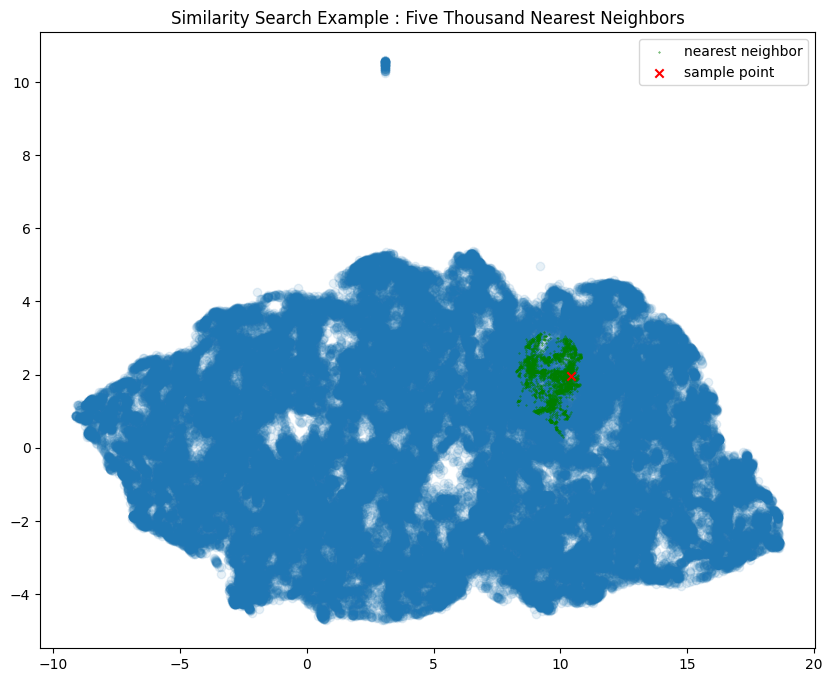

In [6]:
sample = kx.q.qsql.select(train,columns=['signal_'+str(i) for i in range(36)],where='sym=0').pd()
q = sample.to_numpy()[1000:1001]
nn = kx.q.kdbai.search("index_asset_0", q, "vector",0, {'neighbors' : 5000, 'clusters' : 1}) # Search using kdbai

umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.0)
umap.fit(sample.sample(100000))
umapdfv = pd.DataFrame(umap.transform(q),columns=['u0','u1'])
umapdfq = pd.DataFrame(umap.transform(np.array(nn['vector'][1:].py())),columns=['u0','u1'])
umapdf  = pd.DataFrame(umap.transform(sample.sample(100000)),columns=['u0','u1'])

fig,ax = plt.subplots(1,figsize=(10,8))
ax.scatter(umapdf['u0'],umapdf['u1'],alpha=0.1)
ax.scatter(umapdfq['u0'],umapdfq['u1'],alpha=1,color='g',marker='.',s=0.5,label='nearest neighbor')
ax.scatter(umapdfv['u0'],umapdfv['u1'],alpha=1,color='r',marker='x',label='sample point')
ax.legend(loc=1)
ax.set_title("Similarity Search Example : Five Thousand Nearest Neighbors")
plt.show()

### Similarity Search Strategy : Find Similar Historical Market Conditions

We can use the indexes built in the previous section to query our vectors for historical market condidtions where the momentum signals have been similar and make an inference as to the expected return based on the historical performance of the asset.

Using our index for search is much faster than a brute force search. For example here we search one and a half million vectors and return the five thousand nearest neighbours in a few millisconds.

In [7]:
returns = {}
assets  = [0,1,2,3,4,5,6,8,9][:ASSETS]
splits  = range(120)

for asset in assets:
    train_a = kx.q.qsql.select(train,where='sym='+str(asset))
    test_a  = kx.q.qsql.select(test,where='sym='+str(asset))
    print("\nAsset " + str(asset))
    results = {}
    index_name = "index_asset_" + str(asset)
    for i in splits:
        print(i,end=".")
        d = test_a['vector'][(1000*i):(1000*(i+1))]
        p = kx.q.kdbai.search(index_name,d,'y',0, {'neighbors' : 5000, 'clusters' : 1}) # Search using kdbai
        predictions = kx.q.avg(kx.q.flip(p))['y'].np()
        results[i] = ((np.abs(np.array(predictions))>0.00001).astype(int)*np.sign(predictions)*(test_a['y'][(1000*i):(1000*(i+1))]).py()/test_a['v'][(1000*i):(1000*(i+1))].py())
    returns[asset] = pd.concat([pd.Series(results[i],index=test_a['timestamp'][(1000*i):(1000*(i+1))]) for i in splits]).cumsum()


Asset 0
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.

### Similarity Search Returns

We can construct an equally weighted protfolio of our crypto returns. This shows strong performance from the backtest with a Sharpe ratio over seven for the nine assets. 

**Please note this is just an example to demonstrate similarity search. It should not be considered a viable trading strategy in particular we have not taken into consideration transaction costs in this notebook.**

Similarity Search Sharpe Ratio : 5.28


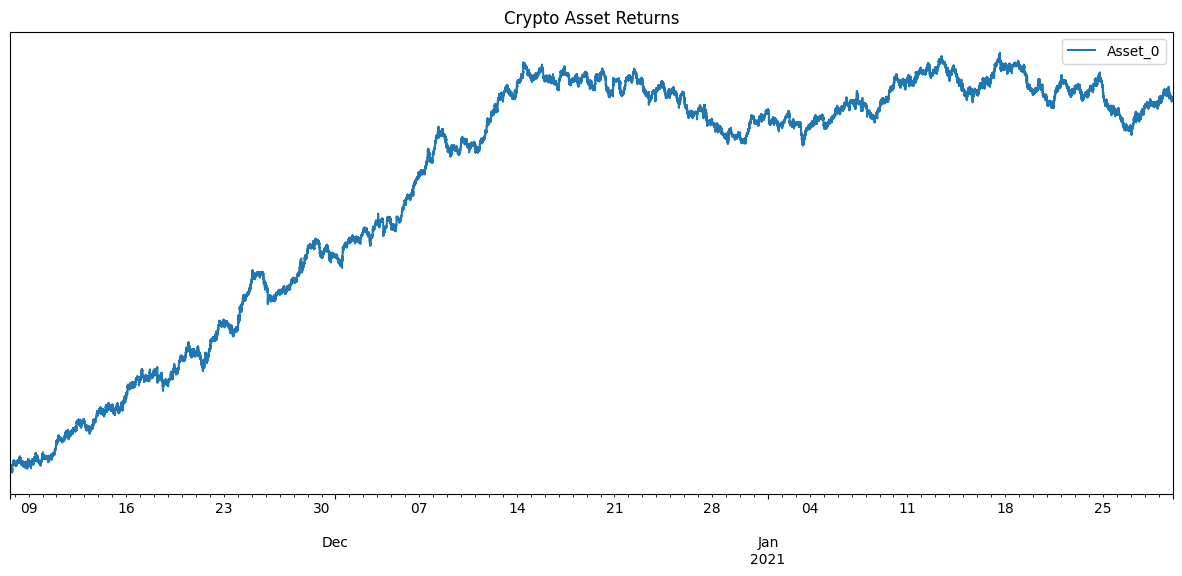

In [8]:
v = pd.DataFrame(returns).apply(np.mean,axis=1).resample('1D').last()
v = ((v.shift(-1)-v)).fillna(0.0)
v = (np.sqrt(252)*v.mean()/v.std())
print("Similarity Search Sharpe Ratio : {:.2f}".format(v))

fig,ax=plt.subplots(1,figsize=(14,6))
ax.set_title('Crypto Asset Returns')
p = pd.DataFrame(returns)
p.columns = [ 'Asset_' + str(i) for i in [0,1,2,3,4,5,6,8,9][:ASSETS]]
p.plot(figsize=(15,6),ax=ax)
ax.set_yticks([])
plt.show()

### Similarity Search Benchmarks

Finally we compare the similarity search strategy to a linear benchmark and a volatility scaled buy and hold strategy. Our similarity search strategy is nicely uncorrelated with both of these indicating a non-naive strategy. In addition to this diversification it also outperforms in both cases. This is suggestive that the similarity search strategy is finding some new non-linear dynamics in these markets.

Correlations :

                  SimilaritySearch  LinearBenchmark  BuyAndHold
SimilaritySearch          1.000000         0.191212    0.098107
LinearBenchmark           0.191212         1.000000    0.274299
BuyAndHold                0.098107         0.274299    1.000000

Sharpe Ratios : 


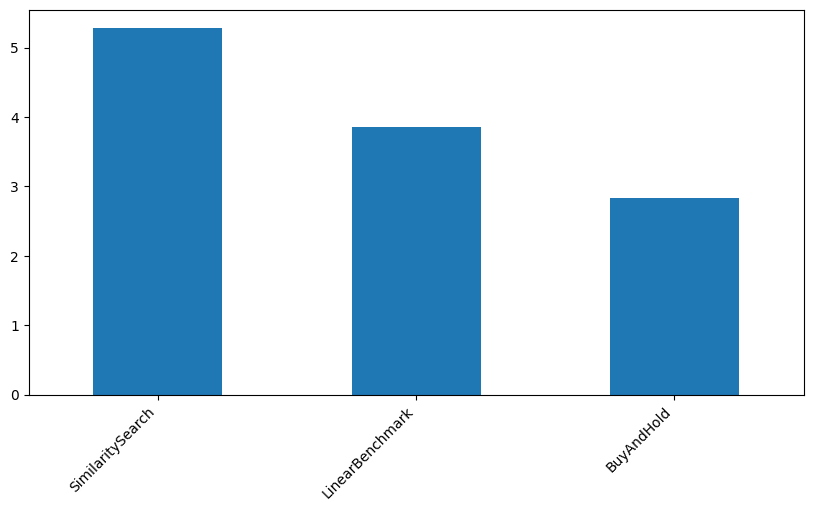

In [9]:
d = pd.DataFrame()
d['SimilaritySearch'] = pd.DataFrame(returns).apply(np.mean,axis=1)
d['LinearBenchmark']  = kx.q("get `:/tmp/linear").np()
d['BuyAndHold']       = kx.q("get `:/tmp/long").np()

v = d.resample('1D').last()
v = ((v.shift(-1)-v)).fillna(0.0)
v = (np.sqrt(252)*v.mean()/v.std())

print("Correlations :\n")
print((d - d.shift(1)).fillna(0.0).corr())

print("\nSharpe Ratios : ")
fig,ax=plt.subplots(1,figsize=(10,5))
v.plot(kind='bar',ax=ax)
ax.set_xticks(range(3),v.index ,rotation=45, ha='right')
plt.show()

---